Project 3: Text analysis of political social media
======

- By Jacob Eisenstein
- For CS 8803-CSS, September 2017



For this project, we'll use scikit learn. Install it with the line below.

In [2]:
from __future__ import print_function

In [3]:
! pip3 install --user sklearn

In [4]:
import codecs #unicode compliance -- maybe not necessary in python 3?
import glob #wildcard filenames

# Data processing

First let's read the data. Here's some hacky code by yours truly.

In [5]:
# some hacky text formatting by yours truly
linebreak = '-----==----==---==-----'
subreddits = dict()
for subreddit_file in sorted(glob.glob('*.txt')):
    print(subreddit_file)
    subreddit = subreddit_file[:-4]
    comments = []
    #with codecs.open('.'.join([subreddit,'txt']),'r','utf-8-sig') as fin:
    with codecs.open(subreddit_file,'r','utf-8-sig') as fin:
        comment = ''        
        for line in fin:
            if not(line.rstrip() == linebreak):
                #print line
                #comment += line.decode('utf-8')
                comment += line
            else:
                comments.append(comment)
                comment = ''
    subreddits[subreddit] = comments

Anarchism.txt
Conservative.txt
Libertarian.txt
Progressive.txt
Socialism.txt


`subreddits` is a dict from labels to lists of text comments

In [6]:
subreddits.keys()

dict_keys(['Progressive', 'Anarchism', 'Libertarian', 'Conservative', 'Socialism'])

In [7]:
for comment in subreddits['Conservative'][:3]:
    print(comment)

What horseshit.


Great article.. 

We all know that this is to push an agenda. It has always been about that. The government wants more control over the energy sector and they are certainly making progress down that path. 

Thank God those clueless women of America have a rich bitch in the White House to tell them how to shop.



**Your turn** take a look at the top three comments in one of the other subreddits

In [8]:
# your code here

## Building feature vectors

The [scikit-learn](http://scikit-learn.org/) library has a convenient package for converting string data into feature vectors, called `CountVectorizer`.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
vect = CountVectorizer()

`CountVectorizer` takes a number of interesting arguments, which we will explore later. 

You can see the documentation by running the cell below.

In [11]:
?CountVectorizer

The input to CountVectorizer is a flattened list of all documents, which we'll produce using this not-very-pythonic for loop.

In [12]:
doc_list = []
y = []
# note the frequent use of `sorted`, to make sure that the labels and the instances are lined up correctly
for subreddit in sorted(subreddits.keys()):
    doc_list += subreddits[subreddit]
    y += [subreddit]*len(subreddits[subreddit])

In [13]:
# let's print a few of the labels
print(y[:3])
print(y[-3:])

['Anarchism', 'Anarchism', 'Anarchism']
['Socialism', 'Socialism', 'Socialism']


`CountVectorizer.fit()` reads the data and produces a feature dictionary: a mapping from word types to indices in a feature vector.

In [14]:
vect.fit(doc_list)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [15]:
len(vect.vocabulary_)

17139

In [16]:
vect.get_feature_names()[12000:12010]

['productively',
 'productivity',
 'products',
 'prof',
 'profess',
 'professed',
 'professes',
 'professing',
 'profession',
 'professional']

**Your turn** 

- Use the `min_df` argument of CountVectorizer to include only words that appear in at least three documents. 
- Print the resulting vocabulary size.
- Find a few words that appear in the original feature set, but not in this one.

In [17]:
vect2 = CountVectorizer(min_df=3) 
vect2.fit(doc_list)
print(len(vect2.vocabulary_))
non_overlap = sorted(set(vect.vocabulary_) - set(vect2.vocabulary_))
print(non_overlap[1300:1400])

5964
['basketball', 'bassackward', 'bastardisation', 'bastardized', 'bastards', 'bastion', 'bastions', 'batch', 'batches', 'bathwater', 'batman', 'batshit', 'battered', 'batteries', 'battery', 'battlegrounds', 'battling', 'battlingdragon', 'baucus', 'baudrillard', 'bauer', 'bauhaus', 'bazookas', 'bbq', 'bc', 'bcce', 'bcj59', 'bcrdistan', 'bcv', 'bds', 'beach', 'beam', 'bearer', 'bearing', 'bears', 'beast', 'beatification', 'beatings', 'beats', 'beauty', 'beavers', 'becaus', 'beck', 'bee', 'beers', 'bees', 'begets', 'beggars', 'begging', 'begining', 'beginner', 'beginnings', 'begins', 'begs', 'begun', 'behave', 'behaved', 'behaviours', 'behindthenews', 'behringer', 'behvaiors', 'belgian', 'belgium', 'believable', 'believer', 'belittle', 'bella', 'bellies', 'belonged', 'belts', 'beltway', 'bemoans', 'bench', 'benchmark', 'bend', 'beneath', 'benefited', 'benefiting', 'benefitted', 'benefitting', 'benevolence', 'benevolent', 'benign', 'bennet', 'benninghoff', 'bent', 'ber', 'berate', 'bera

Now that we have fit the vectorizer, we can use it to transform the data into a vector.

Note that you can fit and transform in one step, using `vect.fit_transform()`

In [18]:
X = vect.transform(doc_list)

In [19]:
X

<4291x17139 sparse matrix of type '<class 'numpy.int64'>'
	with 159004 stored elements in Compressed Sparse Row format>

The output is a sparse matrix: 4291 documents, 17139 words.

"Sparse matrix" means it's stored as key-value pairs, so size grows with number of non-zero elements.

This is essential for working with large-scale datasets.

## Making a training and test set

To estimate the accuracy on unseen data, let's hold out a test set.

Again, sklearn provides a nice function for this.

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.1)

In [22]:
X_train

<3861x17139 sparse matrix of type '<class 'numpy.int64'>'
	with 144245 stored elements in Compressed Sparse Row format>

Same vocabulary size, fewer instances.

In [23]:
X_test

<430x17139 sparse matrix of type '<class 'numpy.int64'>'
	with 14759 stored elements in Compressed Sparse Row format>

In [24]:
3861+430

4291

# Training a classifier

Let's start with logistic regression, which we covered in class a few weeks ago.

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
lr = LogisticRegression()

In [27]:
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

The output of the `fit` command shows some of the parameters that we could use to tune the behavior of the logistic regression classifier. We'll play with those in a moment. For now, let's look at the classifier state.

In [28]:
lr.classes_

array(['Anarchism', 'Conservative', 'Libertarian', 'Progressive',
       'Socialism'],
      dtype='<U12')

In [36]:
lr_class_dict = dict(zip(lr.classes_, range(len(lr.classes_))))

## Examining the coefficients

Before we even consider accuracy, let's look at the top keywords per class.

The coefficients are available in the `coef_` variable

In [29]:
lr.coef_

array([[ 0.02816635, -0.09171729, -0.0565127 , ..., -0.04311113,
        -0.04311113,  0.31043635],
       [ 0.05978944,  0.03829753, -0.09651658, ..., -0.04120992,
        -0.04120992, -0.10168794],
       [-0.00798825, -0.21674091,  0.49258063, ..., -0.05626165,
        -0.05626165, -0.10133215],
       [ 0.04217194,  0.30166685, -0.11404512, ..., -0.06841017,
        -0.06841017, -0.0251092 ],
       [-0.06169858, -0.03540231, -0.17938456, ...,  0.15037128,
         0.15037128, -0.11669757]])

This is an array with one row per class, and one column per feature. 

To get the top features, we can use `argsort`.

`argsort` sorts by ascending order, so we need to reverse it. We do this using `[::-1]`.

In [30]:
# top 5 features for label 0
lr.coef_[0].argsort()[::-1][:10]

array([ 1164,  1162,  1169,  6148, 11448,  1176, 10357, 13588, 16438,  1181])

Finally, to get the features themselves, we can call `vect.get_feature_names()`

In [45]:
[vect.get_feature_names()[i] for i in lr.coef_[lr_class_dict['Socialism']].argsort()[::-1][:10]]

['socialism',
 'socialist',
 'communism',
 'walmart',
 'venezuela',
 'protesters',
 'socialists',
 'propaganda',
 'movie',
 'marx']

**Your turn:** get the top 5 features for a different label.

In [46]:
[vect.get_feature_names()[i] for i in lr.coef_[2].argsort()[::-1][:5]]
# your code here

['libertarianism', 'libertarian', 'bitcoin', 'libertarians', 'fda']

Just for fun, let's scatter plot the weights for the same feature for two different classes.

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


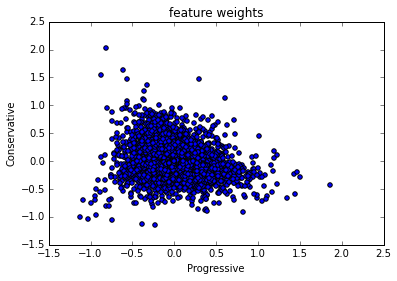

In [48]:
plt.scatter(lr.coef_[3],lr.coef_[1])
plt.xlabel(lr.classes_[3])
plt.ylabel(lr.classes_[1])
plt.title('feature weights');

In [50]:
?sns.regplot

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


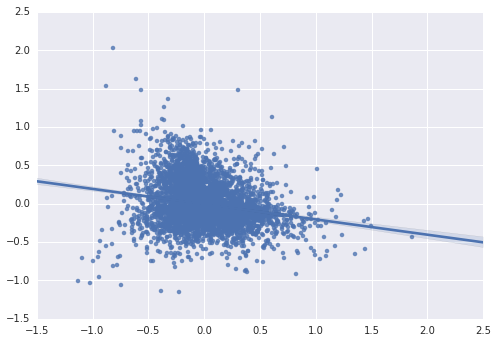

In [49]:
import seaborn as sns
sns.regplot(lr.coef_[3],lr.coef_[1], equ)
plt.xlabel(lr.classes_[3])
plt.ylabel(lr.classes_[1])
plt.show()

Logistic regression employs a regularization penalty to control the norm of the weights. 

Optimize: $max_{\theta} log(P(y_{i} | x_{i} ; \theta))$.

But we don't want to overfit to sparse features, e.g., a word that occurs once for a particular class. So we can add a penalty based on the norm of the coefficient vector.

- In $\ell_2$ regularization, the penalty is on the Euclidean norm, also called the $\ell_2$ norm,
$R(\theta) = \lambda \sqrt{ \sum_i \theta_i^2}$

- In $\ell_1$ regularization, the penalty is on the $\ell_1$ norm,
$R(\theta) = \lambda \sum_i | \theta_i |$

Let's try it.


In [51]:
lr_l1 = LogisticRegression(penalty='l1')

In [52]:
lr_l1.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


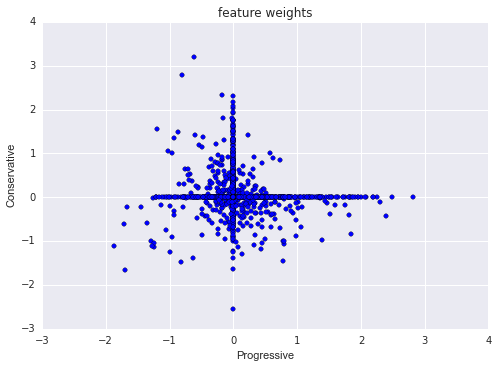

In [53]:
plt.scatter(lr_l1.coef_[3],lr_l1.coef_[1])
plt.xlabel(lr_l1.classes_[3])
plt.ylabel(lr_l1.classes_[1])
plt.title('feature weights');

**Discuss** Try to explain what you see in this figure, and why $\ell_1$ regularization might make it possible to add $n$-gram features.

Regularization drives irrelevant coefficients to zero, so the features that are especially predictive of progressive class have strong weights for progressive but weak for conservative.

In [54]:
print('L1',[vect.get_feature_names()[i] for i in lr_l1.coef_[0].argsort()[::-1][:5]])
print('L2',[vect.get_feature_names()[i] for i in lr.coef_[0].argsort()[::-1][:5]])

L1 ['anarchist', 'anarchists', 'anarchism', 'protestors', 'ancap']
L2 ['anarchist', 'anarchism', 'anarchists', 'feminist', 'pigs']


No big difference in the word lists, but things might be different if we change the regularization parameters $C = \frac{1}{\lambda}$.

## Predictive accuracy

Using the classifier to make predictions is easy.

In [55]:
y_hat = lr.predict(X_test)

In [56]:
y_hat[:5]

array(['Libertarian', 'Socialism', 'Libertarian', 'Progressive',
       'Anarchism'],
      dtype='<U12')

In [57]:
acc = (y_hat == y_test).mean()
print('accuracy: %.3f'%acc)

accuracy: 0.423


**Your turn**: compute the number of true positives, false negatives, and false positives for the `Socialism` label

In [58]:
import numpy as np

In [59]:
label = 'Socialism'
# your code here

In [60]:
print(tp,fp,fn)

NameError: name 'tp' is not defined

`sklearn` has some useful functions here as well

In [61]:
from sklearn.metrics import accuracy_score, f1_score

In [62]:
accuracy_score(y_test,y_hat)

0.42325581395348838

Recall that $f_1$ is the geometric mean of recall and precision.

*Macro*-averaging means average across labels.

In this case, we have roughly the same number of documents per label, so macro and micro should be roughly the same.

In [79]:
f1_score(y_test,y_hat,average='macro')

0.4134410346651185

In [80]:
f1_score(y_test,y_hat,average='micro')

0.42325581395348838

# Improving the classifier

**Your turn** Try improving the classifier by:

- Not lowercasing the input
- Only including words that appear in at least two documents

In [81]:
vect3 = CountVectorizer() # your code here

In [82]:
X = vect3.fit_transform(doc_list)

In [83]:
X.shape

(4291, 9309)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.1)

**Your turn** Run logistic regression, compute accuracy and $F_1$

# Support vector machines

Support vector machines (SVMs) are another classifier. This code shows you how to try it.

In [91]:
from sklearn.svm import LinearSVC

In [92]:
svc = LinearSVC(C=0.01) 

In [93]:
svc.fit(X_train,y_train)

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [94]:
y_hat = svc.predict(X_test)

In [95]:
accuracy_score(y_test,y_hat)

0.4511627906976744

In [96]:
print(f1_score(y_test,y_hat,average='macro'),f1_score(y_test,y_hat,average='micro'))

0.429545466194 0.451162790698
